In [888]:
import datetime as dt

import pandas as pd
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [889]:
colors = ['#003f5c','#7a5195', '#ef5675', '#fdb534']

In [890]:
df_ = pd.read_csv('flo_data_20k.csv')
df = df_.copy()

In [891]:
df.head(10)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,Desktop,Offline,2018-11-18,2021-03-13,2018-11-18,2021-03-13,1.0000,2.0000,150.8700,49.9900,[KADIN]
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,Android App,Android App,2020-03-04,2020-10-18,2020-10-18,2020-03-04,3.0000,1.0000,59.9900,315.9400,[AKTIFSPOR]
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,Mobile,Offline,2020-05-15,2020-08-12,2020-05-15,2020-08-12,1.0000,1.0000,49.9900,113.6400,[COCUK]
8,cfbda69e-5b4f-11ea-aca7-000d3a38a36f,Android App,Android App,2020-01-23,2021-03-07,2021-03-07,2020-01-25,3.0000,2.0000,120.4800,934.2100,"[ERKEK, COCUK, KADIN]"
9,1143f032-440d-11ea-8b43-000d3a38a36f,Mobile,Mobile,2019-07-30,2020-10-04,2020-10-04,2019-07-30,1.0000,1.0000,69.9800,95.9800,"[KADIN, AKTIFSPOR]"


In [892]:
df.shape

(19945, 12)

In [893]:
df.columns

Index(['master_id', 'order_channel', 'last_order_channel', 'first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 'interested_in_categories_12'], dtype='object')

In [894]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


In [895]:
df.isnull().sum()

master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

In [896]:
df.dtypes

master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object

In [897]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    inter_quantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * inter_quantile_range
    low_limit = quartile1 - 1.5 * inter_quantile_range
    return low_limit, up_limit

In [898]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

In [899]:
replace_with_thresholds(df, 'order_num_total_ever_online')
replace_with_thresholds(df, 'order_num_total_ever_offline')
replace_with_thresholds(df, 'customer_value_total_ever_offline')
replace_with_thresholds(df, 'customer_value_total_ever_online')

In [900]:
df.sample(5)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
6109,bed3925a-f95f-11e9-b138-000d3a38a36f,Mobile,Offline,2019-10-28,2020-07-25,2020-04-27,2020-07-25,1.0000,4.0000,448.4300,90.9300,"[AKTIFCOCUK, COCUK, KADIN]"
8120,52561362-bd38-11ea-aa61-000d3a38a36f,Mobile,Mobile,2020-07-03,2021-05-20,2021-05-20,2021-05-17,1.0000,3.0000,938.8100,578.5700,"[ERKEK, KADIN, AKTIFSPOR]"
11132,8db16222-23cd-11ea-8523-000d3a38a36f,Ios App,Ios App,2019-09-07,2020-09-29,2020-09-29,2019-12-15,1.0000,3.0000,229.9600,212.1500,[KADIN]
11257,1719f0b6-b12c-11e9-9757-000d3a38a36f,Mobile,Offline,2019-01-14,2021-03-01,2020-01-20,2021-03-01,4.0000,1.0000,70.8500,260.6800,[]
3975,c17b7744-23f7-11ea-8523-000d3a38a36f,Android App,Android App,2019-02-22,2021-04-14,2021-04-14,2019-02-22,5.0000,1.0000,49.9900,401.9500,[ERKEK]


In [901]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.0920,3.8095,1.0000,1.0000,2.0000,4.0000,48.0000
order_num_total_ever_offline,19945.0000,1.8862,1.4347,1.0000,1.0000,1.0000,2.0000,16.0000
customer_value_total_ever_offline,19945.0000,251.9213,251.0237,10.0000,99.9900,179.9800,319.9700,3020.0000
customer_value_total_ever_online,19945.0000,489.7057,632.6098,12.9900,149.9800,286.4600,578.4400,7800.0000


In [902]:
df['order_num_total'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['customer_value_total'] = (df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline'])

In [903]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR],2.0000,209.9800


In [904]:
df['first_order_date'] = pd.to_datetime(df['first_order_date'])
df['last_order_date'] = pd.to_datetime(df['last_order_date'])
df['last_order_date_online'] = pd.to_datetime(df['last_order_date_online'])
df['last_order_date_offline'] = pd.to_datetime(df['last_order_date_offline'])

In [905]:
df.dtypes

master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime64[ns]
last_order_date_offline              datetime64[ns]
order_num_total_ever_online                 float64
order_num_total_ever_offline                float64
customer_value_total_ever_offline           float64
customer_value_total_ever_online            float64
interested_in_categories_12                  object
order_num_total                             float64
customer_value_total                        float64
dtype: object

In [906]:
today_date = dt.datetime(2021, 6, 1)

In [907]:
#cltv_df.head()

In [908]:
cltv_df = pd.DataFrame()

In [909]:
cltv_df['customer_id'] = df['master_id']

In [910]:
cltv_df['recency_cltv_weekly'] = ((df['last_order_date'] - df['first_order_date']).astype('timedelta64[D]')) / 7

In [911]:
cltv_df['T_weekly'] = ((today_date - df['first_order_date']).astype('timedelta64[D]')) / 7

In [912]:
cltv_df['frequency'] = df['order_num_total']

In [913]:
cltv_df['monetary_cltv_avg'] = df['customer_value_total'] / df['order_num_total']

In [914]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [915]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900


In [916]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [917]:
bgf.fit(cltv_df['frequency'], cltv_df['recency_cltv_weekly'], cltv_df['T_weekly'])

C:\Users\ezgie\anaconda3\envs\cltv-prediction\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [918]:
cltv_df['exp_sales_3_month'] = bgf.predict(4 * 3, cltv_df['frequency'], cltv_df['recency_cltv_weekly'],
                                           cltv_df['T_weekly'])

In [919]:
cltv_df['exp_sales_6_month'] = bgf.predict(4 * 6, cltv_df['frequency'], cltv_df['recency_cltv_weekly'],
                                           cltv_df['T_weekly'])

In [920]:
cltv_df

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921
...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.1429,88.4286,3.0000,133.9867,0.4858,0.9716
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.2857,65.2857,2.0000,195.2350,0.4804,0.9609
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.7143,89.8571,3.0000,210.9800,0.4816,0.9632
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.4286,113.8571,6.0000,168.2950,0.6102,1.2204


In [921]:
cltv_df.sort_values("exp_sales_3_month", ascending=False)[:10]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.7143,40.0000,29.0000,165.2976,3.3740,6.7479
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.8571,33.2857,25.0000,97.4396,3.1424,6.2848
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.0000,46.4286,27.0000,141.3548,3.0013,6.0026
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.1429,111.8571,43.0000,157.1126,2.9780,5.9561
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.1429,147.1429,49.0000,161.8467,2.8299,5.6598
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.7143,64.1429,29.0000,168.8810,2.7934,5.5869
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.5714,113.4286,40.0000,176.2000,2.7635,5.5270


In [922]:
cltv_df.sort_values("exp_sales_6_month", ascending=False)[:10]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.7143,40.0000,29.0000,165.2976,3.3740,6.7479
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.8571,33.2857,25.0000,97.4396,3.1424,6.2848
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.0000,46.4286,27.0000,141.3548,3.0013,6.0026
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.1429,111.8571,43.0000,157.1126,2.9780,5.9561
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.1429,147.1429,49.0000,161.8467,2.8299,5.6598
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.7143,64.1429,29.0000,168.8810,2.7934,5.5869
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.5714,113.4286,40.0000,176.2000,2.7635,5.5270


In [923]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [924]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [925]:
cltv_df['exp_average_value'] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                       cltv_df['monetary_cltv_avg'])

In [926]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251


In [927]:
cltv_6_month = ggf.customer_lifetime_value(bgf,
                                           cltv_df['frequency'],
                                           cltv_df['recency_cltv_weekly'],
                                           cltv_df['T_weekly'],
                                           cltv_df['monetary_cltv_avg'],
                                           time=6,
                                           freq="W",
                                           discount_rate=0.01)

In [928]:
cltv_df['cltv_6_month'] = cltv_6_month

cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117


In [929]:
cltv_df.sort_values('cltv_6_month', ascending=False)[:20]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv_6_month
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4.0000,1401.8000,1.0944,2.1888,1449.0605,3327.7770
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.1429,11.0000,758.0855,1.9701,3.9402,767.3606,3172.3944
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7.0000,1106.4671,0.7222,1.4445,1127.6115,1708.9821
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.5714,16.0000,501.8737,1.5653,3.1306,506.1667,1662.6135
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123,166.7123,1628.8874
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.4286,8.0000,601.2262,1.2655,2.5309,611.4926,1623.8127
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2.0000,862.6900,0.7939,1.5878,923.6800,1538.8559
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614,262.0729,1529.2280
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676,229.6069,1485.8192
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.5714,3.0000,743.5867,0.8716,1.7431,778.0504,1422.9997


In [930]:
cltv_df['cltv_segment'] = pd.qcut(cltv_df['cltv_6_month'], 4, labels=['D', 'C', 'B', 'A'])

In [931]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv_6_month,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117,D


In [932]:
cltv_df.groupby('cltv_segment').agg(['max', 'mean', 'count']).T

cltv_segment                      D         C         B         A
recency_cltv_weekly max    432.5714  433.0000  415.5714  433.4286
                    mean   139.0002   92.6295   81.9884   67.4271
                    count 4987.0000 4986.0000 4986.0000 4986.0000
T_weekly            max    436.2857  434.7143  423.5714  437.1429
                    mean   162.1832  112.8183  100.3265   82.5497
                    count 4987.0000 4986.0000 4986.0000 4986.0000
frequency           max     18.0000   32.0000   50.0000   57.0000
                    mean     3.7688    4.4047    5.0927    6.6466
                    count 4987.0000 4986.0000 4986.0000 4986.0000
monetary_cltv_avg   max    284.9850  342.8400  539.9850 1401.8000
                    mean    93.1516  125.7885  160.6366  228.8311
                    count 4987.0000 4986.0000 4986.0000 4986.0000
exp_sales_3_month   max      1.0498    1.5684    1.7822    4.6561
                    mean     0.4089    0.5254    0.6011    0.7730
                    count 4987.0000 4986.0000 4986.0000 4986.0000
exp_sales_6_month   max      2.0995    3.1369    3.5643    9.3123
                    mean     0.8178    1.0509    1.2022    1.5461
                    count 4987.0000 4986.0000 4986.0000 4986.0000
exp_average_value   max    306.5909  368.3901  578.9751 1449.0605
                    mean    98.6911  132.2506  168.0006  238.0240
                    count 4987.0000 4986.0000 4986.0000 4986.0000
cltv_6_month        max    112.2454  165.4689  240.0579 3327.7770
                    mean    80.3405  138.3115  199.5328  362.3155
                    count 4987.0000 4986.0000 4986.0000 4986.0000

Text(0, 0.5, 'profit')

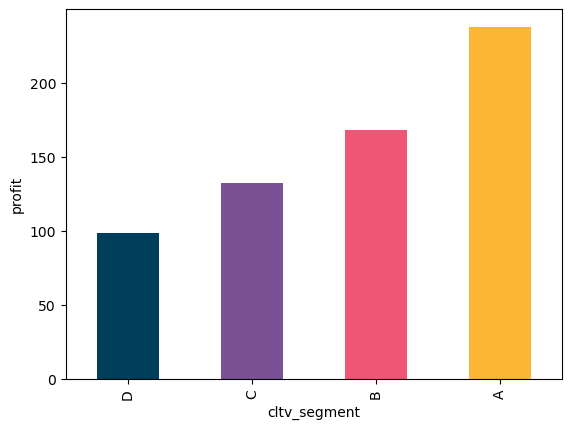

In [933]:
from matplotlib import pyplot as plt

cltv_df.groupby('cltv_segment').agg('exp_average_value').mean().plot(kind='bar', color=colors)

plt.ylabel('profit')

Text(0, 0.5, 'expected purchase')

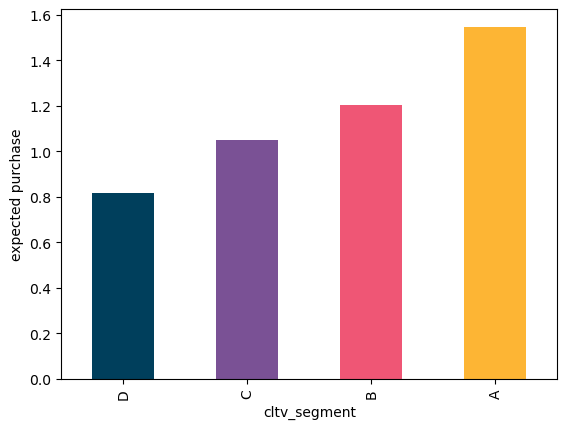

In [934]:
cltv_df.groupby('cltv_segment').agg('exp_sales_6_month').mean().plot(kind='bar', color=colors)

plt.ylabel('expected purchase')

Text(0, 0.5, 'cltv')

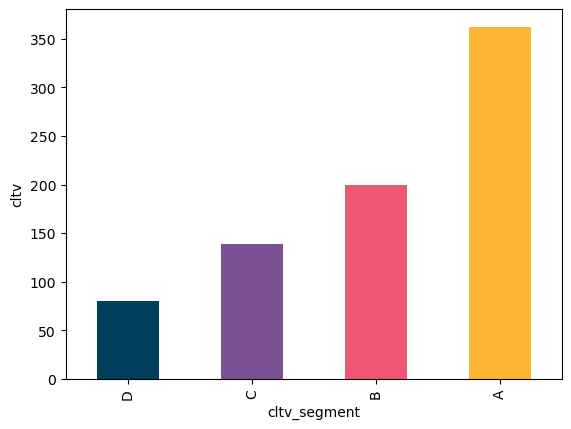

In [935]:
cltv_df.groupby('cltv_segment').agg('cltv_6_month').mean().plot(kind='bar', color=colors)

plt.ylabel('cltv')

<AxesSubplot:xlabel='cltv_segment', ylabel='count'>

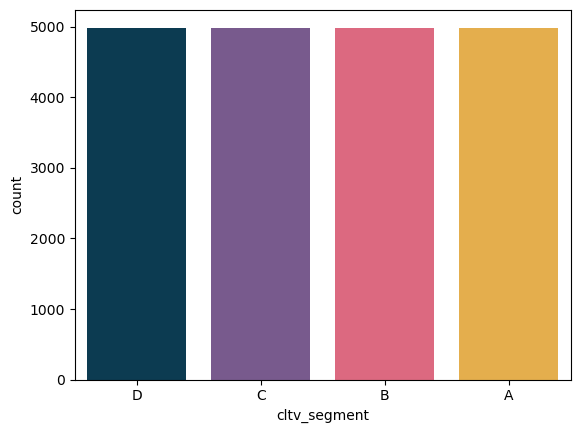

In [936]:
sns.countplot(x=cltv_df['cltv_segment'], palette=colors)